# Training and evaluating a fully connected neural network for DNA sequences

## 1. Introduction

## 2. Load data

In [520]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score
from timeit import default_timer as timer
import datetime

# Specify what we will be working on 'cpu' or 'cuda' (GPU)
device = torch.device('cpu')

In [521]:
# Load data
my_dataset = pd.read_csv("dna_sequence_dataset.csv")

# Specificy data (X) and targets (y), since this is an example, we only use the first 50000 samples, decrease
# this number if it seems the the training goes slowly
X = my_dataset["dna_sequence"][:50000]
y = my_dataset["target"][:50000]

The input data consists of DNA sequences, and the targets are binary (0 or 1)

In [399]:
X.head()

0    AAAAAAAAAATA
1    AAAAAAAAAGAG
2    AAAAAAAAATCA
3    AAAAAAAAATTC
4    AAAAAAAACAAA
Name: dna_sequence, dtype: object

In [400]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

## 3. Create Dataset and DataLoader object

Before we can train our neural net, we need to split our dataset into a **training**, **validation** and **testing** set. 

 - The training set is used to train our model (70% of dataset)
 - The validation set is used to determine the number of epochs that the model is trained for (10% of dataset)
 - The testing set is used to assess the model's performance on unseen data. (20% of dataset)

The **Dataset_fcANN** class is a custom class that defines the data and target values (We will class this a sample from now on). 
This class has to be a child class from PyTorch's basic Dataset class and it should overwrite at least 
the **init**, **len** and **getitem** methods.

In this case, our custom dataset class simply convert the DNA sequence into a binary matrix using the function **one_hot_sequence**, this matrix is then flattened and converted into a tensor (a multi-dimensional vector), and finallly it is moved to the device (CPU or GPU).


In [401]:
def one_hot_sequence(seq):
    """Convert a DNA sequence into a binary matrix.
       
    Args:
        seq (str): input DNA sequence

    Returns:
        m (numpy array): binary matrix

    """
    d = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    length = len(seq)
    m = np.zeros((4, length), dtype='float32')
    for i, b in enumerate(seq):
        m[d[b]][i] = 1   
    return m

In [402]:
class Dataset_fcANN(Dataset):
    def __init__(self, X, y):
        "Initialization"
        self.X = X
        self.y = y
    
    def __len__(self):
        "Denotes the total number of samples"
        return len(self.X)

    def __getitem__(self, idx):
        "Generates one data and target pair"
        # Select DNA sequence at the position in the dataset specified by idx
        data = self.X.iloc[idx]
        
        # Convert the DNA sequence into a binary matrix
        data = one_hot_sequence(data)
        
        # Flatten the binary matrix and convert the numpy array into a PyTorch tensor
        data = torch.from_numpy(data.flatten())
            
        # Move the tensor to the device, depending on the loss function that you are using,
        # you may want to change the datatype 
        data = data.to(device, dtype=torch.float32)
        
        # Select the target value at the position in the dataset specified by idx, and convert into a numpy array
        target = np.array(self.y.iloc[idx])
        
        # Convert the numpy array into a PyTorch tensor
        target = torch.from_numpy(target)
        
        # Move the tensor to the device
        target = target.to(device, dtype=torch.long)
        
        # Return data and target tensors as a tuple
        return data, target

The **DataLoader** class defines how the samples are read by the neural network. We set the mini-batch size to 100, and we also set drop_last to True. drop_last ensures that if the last mini-batch of a dataset contains just 1 samples (i.e. number of samples % number of mini-batches = 1), then this data value is dropped so that no errors occur. I could calculate if it is necessary to do this for our example dataset, but since we have so many samples (), we can afford to drop one.

We enable shuffle to ensure that there is no bias in the data before we make a split, and stratify is used to make sure that the distribution of our target values (0 and 1) is the same for each split (training, validation and testing).

In [501]:
# Create testing set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, stratify=y)

# Create training and validation set (7/8th of 80% = 70%, and 1/8th of 80% = 10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=7/8, test_size=1/8, shuffle=True, stratify=y_train_val)

# Create dictionary with datasets for training, validation and testing set
datasets = {
    "train": Dataset_fcANN(X_train, y_train),
    "valid": Dataset_fcANN(X_val, y_val),
    "test": Dataset_fcANN(X_test, y_test)
}

# Set mini-batch size parameter
batch_size = 100

# Create dictionary with dataloaders for training, validation and testing set
dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=True, drop_last=True),
    "valid": DataLoader(datasets["valid"], batch_size=batch_size, shuffle=True, drop_last=True),
    "test": DataLoader(datasets["test"], batch_size=batch_size, shuffle=True, drop_last=True)
}

## 4. Create fully-connect Artificial Neural Network

Next, we define the most important part of this notebook: the fully-connected artificial neural network. This neural network includes 1 input layer, 1 hidden layer, 1 output layer, and 2 batch normalization layers.
The output layer consists of 2 output nodes: one for each possible target value (0 or 1).

This neural network is encoded by the **fcANN** class, which is a child class from PyTorch's nn.Module class, and it has to define a **forward** method. This method describes one forward pass of a data value through the neural network.

In [502]:
class fcANN(nn.Module):
    def __init__(self, in_size=48, hidden_size=192, out_size=2, dropoutp=0.2, epochs=0):
        super(fcANN, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(in_size, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(p=dropoutp)
        self.fc2 = nn.Linear(hidden_size, out_size)
        
        # Define number of epochs that the model has been trained for
        self.epochs = epochs

    def forward(self, x):
        x = self.dropout(F.relu(self.bn(self.fc1(x))))
        out = self.fc2(x)
        return out

In [503]:
# Define model using default parameters
model = fcANN() 

# View model
model

fcANN(
  (fc1): Linear(in_features=48, out_features=192, bias=True)
  (bn): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=192, out_features=2, bias=True)
)

## 5. Train neural network

To train the neural network, we use the custom **train** function. This function trains the neural network using the data in the dataloader dictionary that we created earlier.

In [547]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=3,
          print_every=1):
    """Train a PyTorch neural network.
       
       This function is inspired by code found in this notebook:
       https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb

    Args:
        model (PyTorch model): neural network to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns:
        model (PyTorch model): trained neural network   
        
    """
    ########################
    # Initialize variables #
    ######################## 
    
    # Create timer
    overall_start = timer()
    
    # Set number of epochs mdoel was trained for to 0
    model.epochs = 0
    
    # Initialize variable for tracking how many times that 
    # the loss has not lowered after one epoch of training
    epochs_no_improve = 0
    
    # Initialize variable for tracking the validation loss
    # We set this variable to +Infinity so that the first time that the model is trained, 
    # it will always be lower, and thus continue training
    valid_loss_min = np.Inf
    
    # Initialize variable for tracking if the training was stopped early
    early_stopping = False
    
    # Initialize dictionary for tracking different metrics
    # This dictionary should contain at least a "loss", "target", and "output" key.
    metrics_dict = {'loss': {'train': [], 'valid': []},
                    'target': {'train': [], 'valid': []}, 
                    'output': {'train': [], 'valid': []},
                    'accuracy': {'train': [], 'valid': []},
                    'roc_auc': {'train': [], 'valid': []},
                    'pr_auc': {'train': [], 'valid': []}}
    
    assert all([x in metrics_dict for x in ["loss", "target", "output"]]), 'Metrics dictionary must contain at least a "loss", "target", and "output" key.'
       
    for epoch in range(n_epochs):
                   
        # Initialize metrics to record a new epoch
        # We do this for both the training set and the validation set
        for mode in ['train', 'valid']:
            metrics_dict['loss'][mode].append(0)
            # Value is 2, because we have 2 nodes in the output layer (output is numpy array with length 2)
            metrics_dict['output'][mode].append(np.empty((0, 2))) 
            metrics_dict['target'][mode].append([])
            metrics_dict['accuracy'][mode].append([])
            metrics_dict['roc_auc'][mode].append([])
            metrics_dict['pr_auc'][mode].append([])

        # Set model to training
        model.train()
        start = timer()
        
        #################
        # Training loop #
        #################

        for mini_batch_number, (data, target) in enumerate(train_loader):

            # Clear gradients
            optimizer.zero_grad()
            
            # Predicted outputs
            output = model(data)
            
            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()
         
            # Multiply average loss by number of examples in a minibatch
            metrics_dict['loss']['train'][-1] += loss.item() * len(target)

            # Append target and output to lists
            metrics_dict['target']['train'][-1] = np.append(metrics_dict['target']['train'][-1], target.data.cpu().numpy())
            metrics_dict['output']['train'][-1] = np.vstack((metrics_dict['output']['train'][-1], output.data.cpu().numpy()))
        
            # Print training completion percentage
            print(f'Epoch: {epoch+1}\t{100 * (mini_batch_number + 1) / len(train_loader):6.2f}% complete ({str(datetime.timedelta(seconds=round(timer() - start)))})', end='\r')
                
        ###################
        # Validation loop #
        ###################
        
        # Don't need to keep track of gradients
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            for data, target in valid_loader:
                                
                # Predicted outputs
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                
                # Multiply average loss by number of examples in a minibatch and add to metrics dictionary
                metrics_dict['loss']['valid'][-1] += loss.item() * len(target)

                # Append target and output to lists and add to metrics dictionary
                metrics_dict['target']['valid'][-1] = np.append(metrics_dict['target']['valid'][-1], target)
                metrics_dict['output']['valid'][-1] = np.vstack((metrics_dict['output']['valid'][-1], output))
        
        # Count epochs that model was trained for
        model.epochs += 1
        
        #####################    
        # Calculate metrics #
        #####################
        
        # Loss over one epoch is the average of the loss over the entire dataset
        metrics_dict['loss']['train'][-1] /= len(train_loader.dataset)
        metrics_dict['loss']['valid'][-1] /= len(valid_loader.dataset)

        # At the end of the validation, we can calculate metrics to be added to metrics dictionary 
        for mode in ['train', 'valid']:

            # Add accuracy to the metrics dictionary       
            pred = np.argmax(metrics_dict['output'][mode][-1], axis=1)       
            target = metrics_dict['target'][mode][-1]
            correct = (pred == target)
            metrics_dict['accuracy'][mode][-1] = sum(correct) / len(correct)

            # Add ROC AUC to the metrics dictionary
            fpr, tpr, _ = roc_curve(metrics_dict['target'][mode][-1], 
                                    metrics_dict['output'][mode][-1][:, 1]) # select positive class
            metrics_dict['roc_auc'][mode][-1] = auc(fpr, tpr)

            # Add PR AUC to the metrics dictionary
            pr_auc = average_precision_score(metrics_dict['target'][mode][-1], 
                                             metrics_dict['output'][mode][-1][:, 1]) # select positive class132 / 024
            metrics_dict['pr_auc'][mode][-1] = pr_auc
        
        # Print emtrics
        output_str = [f'\n\t\tTraining loss: {metrics_dict["loss"]["train"][-1]:.4f}\t\t\tValidation loss: {metrics_dict["loss"]["valid"][-1]:.4f}']
        output_str.append(f'\n\t\tTraining accuracy: {metrics_dict["accuracy"]["train"][-1]:.4f}\t\tValidation accuracy: {metrics_dict["accuracy"]["valid"][-1]:.4f}')
        output_str.append(f'\n\t\tTraining roc_auc: {metrics_dict["roc_auc"]["train"][-1]:.4f}\t\tValidation roc_auc: {metrics_dict["roc_auc"]["valid"][-1]:.4f}')
        output_str.append(f'\n\t\tTraining pr_auc: {metrics_dict["pr_auc"]["train"][-1]:.4f}\t\t\tValidation pr_auc: {metrics_dict["pr_auc"]["valid"][-1]:.4f}')
        
        # Save the model if the validation loss decreases
        if metrics_dict['loss']['valid'][-1] < valid_loss_min: # valid_loss_min is np.Inf for the first Epoch

            # Save model
            torch.save(model.state_dict(), save_file_name)
            output_str.append(f'\t\tSaving...')

            # Track improvement
            epochs_no_improve = 0 # Reset tracker to 0, since the loss decreased
            best_epoch = epoch

            # Set the validation loss to the current validation loss
            valid_loss_min = metrics_dict['loss']['valid'][-1]

        # Otherwise increment count of epochs with no improvement
        else:
            epochs_no_improve += 1
            
            # Trigger early stopping
            if epochs_no_improve >= max_epochs_stop:
                early_stopping=True
                break

         # Print every n epochs (e.g. 2, print only even epochs)
        if (model.epochs) % print_every == 0:
            print(''.join(output_str)+'\n')        

    ########################
    # Report final metrics #
    ########################
    
    # Calculate time function took in total
    total_time = round(timer() - overall_start)
    total_time = str(datetime.timedelta(seconds=total_time))
    
                
    # Load the best model
    model.load_state_dict(torch.load(save_file_name))  
    model.epochs = best_epoch + 1
    
    # Attach the optimizer
    model.optimizer = optimizer

    # Report final metrics
    early_stopping_str = f'Early Stopping! ' if early_stopping else ''
    output_str = [f'{early_stopping_str}Total epochs: {epoch+1} ({total_time}), Best epoch: {model.epochs}, with loss: {metrics_dict["loss"]["valid"][model.epochs-1]:.4f}']
    output_str.append(f'accuracy: {metrics_dict["accuracy"]["valid"][model.epochs-1]:.4f}')
    output_str.append(f'roc_auc: {metrics_dict["roc_auc"]["valid"][model.epochs-1]:.4f}')
    output_str.append(f'pr_auc: {metrics_dict["pr_auc"]["valid"][model.epochs-1]:.4f}')
    print(', '.join(output_str))

    return model, metrics_dict

Before we can do train the model, we have to first define a **loss function**, and an **optimizer**.
As a loss function, we use the log loss (a.k.a the CrossEntropyLoss). This is the standard loss used for a binary prediction problem. The optimizer is the type of gradient descent algorithm that we use (Adam).

In [548]:
criterion = nn.CrossEntropyLoss()

# lr is the learning rate, low = slower but more accurate learning, high = faster but less accurate learning
# 1e-3 is a good middle ground value
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.to(device)

model, metrics_dict = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    save_file_name=f'delete_me.pt',
    n_epochs=3,
    max_epochs_stop=3)

Epoch: 1	100.00% complete (0:00:02)
		Training loss: 0.3461			Validation loss: 0.3748
		Training accuracy: 0.8743		Validation accuracy: 0.8668
		Training roc_auc: 0.7726		Validation roc_auc: 0.7134
		Training pr_auc: 0.5084			Validation pr_auc: 0.4432		Saving...

Epoch: 2	100.00% complete (0:00:02)
		Training loss: 0.3453			Validation loss: 0.3737
		Training accuracy: 0.8743		Validation accuracy: 0.8676
		Training roc_auc: 0.7728		Validation roc_auc: 0.7165
		Training pr_auc: 0.5128			Validation pr_auc: 0.4493		Saving...

Epoch: 3	100.00% complete (0:00:02)
		Training loss: 0.3440			Validation loss: 0.3763
		Training accuracy: 0.8732		Validation accuracy: 0.8682
		Training roc_auc: 0.7780		Validation roc_auc: 0.7131
		Training pr_auc: 0.5105			Validation pr_auc: 0.4441

Total epochs: 3 (0:00:06), Best epoch: 2, with loss: 0.3737, accuracy: 0.8676, roc_auc: 0.7165, pr_auc: 0.4493


## 6. Visualize metrics

Next, we use functions to visualize the output

In [549]:
def plot_auc_roc(metrics_dict, epoch, mode="valid"):
    
    assert mode in["train", "valid"], 'mode must be "train" or "valid"'
    
    fig, ax = plt.subplots(1,1)
    fpr, tpr, _ = roc_curve(metrics_dict['target'][mode][epoch-1],
                            metrics_dict['output'][mode][epoch-1][:, 1]) # select positive class
    
    ax.plot(fpr, tpr, label=f'area = {metrics_dict["roc_auc"][mode][epoch-1]:2.2f}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC curve')
    ax.legend(loc='lower right')
    print(ax)

AxesSubplot(0.125,0.125;0.775x0.755)


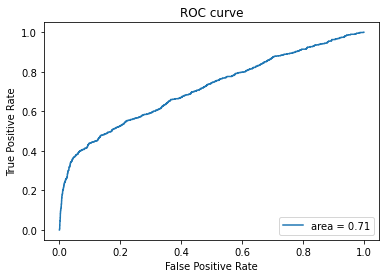

In [550]:
plot_auc_roc(metrics_dict, epoch=1, mode="valid")